В цьому завданні я знову працюю з даними зі змагання ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0).

Тут я побудую рішення задачі класифікації з використанням алгоритмів бустингу: XGBoost та LightGBM, а також використаю бібліотеку HyperOpt для оптимізації гіперпараметрів.

0. Зчитую дані `train.csv` в змінну `raw_df` та використовую функції наведені нижче аби розділити дані на тренувальні та валідаційні і розділити дані на ознаки з матириці Х та цільову змінну. Назви змінних `train_inputs, train_targets, train_inputs, train_targets`.

  Наведений скрипт - частина отриманого мною скрипта для обробки даних. Я тут не виконуємо масштабування та обробку категоріальних змінних, бо хочу це делегувати алгоритмам, які буду використовувати.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from typing import Tuple, Dict, Any


def split_train_val(df: pd.DataFrame, target_col: str, test_size: float = 0.2, random_state: int = 42) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Split the dataframe into training and validation sets.

    Args:
        df (pd.DataFrame): The raw dataframe.
        target_col (str): The target column for stratification.
        test_size (float): The proportion of the dataset to include in the validation split.
        random_state (int): Random state for reproducibility.

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame]: Training and validation dataframes.
    """
    train_df, val_df = train_test_split(df, test_size=test_size, random_state=random_state, stratify=df[target_col])
    return train_df, val_df


def separate_inputs_targets(df: pd.DataFrame, input_cols: list, target_col: str) -> Tuple[pd.DataFrame, pd.Series]:
    """
    Separate inputs and targets from the dataframe.

    Args:
        df (pd.DataFrame): The dataframe.
        input_cols (list): List of input columns.
        target_col (str): Target column.

    Returns:
        Tuple[pd.DataFrame, pd.Series]: DataFrame of inputs and Series of targets.
    """
    inputs = df[input_cols].copy()
    targets = df[target_col].copy()
    return inputs, targets

In [ ]:
raw_df = pd.read_csv('train.csv')

In [ ]:
train_df, val_df = split_train_val(raw_df, 'Exited')

In [ ]:
train_df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
7180,7180,15652218.0,Mays,682.0,France,Male,30.0,1.0,131394.56,1.0,1.0,1.0,143952.24,0.0
10393,10393,15592937.0,Ch'eng,684.0,France,Female,39.0,2.0,178058.06,1.0,1.0,0.0,145518.31,0.0
80,80,15774586.0,Ch'in,705.0,Germany,Male,35.0,6.0,116320.68,2.0,1.0,0.0,174431.01,0.0
3365,3365,15780572.0,K?,669.0,Spain,Male,58.0,0.0,0.00,2.0,0.0,1.0,51565.98,0.0
12236,12236,15642099.0,Trevisani,707.0,France,Male,21.0,3.0,0.00,2.0,1.0,1.0,148564.76,0.0


In [ ]:
input_cols = train_df.columns[1:-1].tolist()
target_col = train_df.columns[-1]

In [ ]:
X_train, Y_train = separate_inputs_targets(train_df, input_cols, target_col)

In [ ]:
X_val, Y_val = separate_inputs_targets(val_df, input_cols, target_col)

In [ ]:
X_test = pd.read_csv('test.csv', index_col=0)

In [ ]:
X_train.dtypes

CustomerId         float64
Surname             object
CreditScore        float64
Geography           object
Gender              object
Age                float64
Tenure             float64
Balance            float64
NumOfProducts      float64
HasCrCard          float64
IsActiveMember     float64
EstimatedSalary    float64
dtype: object

1. В тренувальному та валідаційному наборі перетворюю категоріальні ознаки на тип `category`.

In [ ]:
cat_features = X_train.select_dtypes(include='object').columns
X_train[cat_features] = X_train[cat_features].astype('category')
X_val[cat_features] = X_val[cat_features].astype('category')

In [ ]:
cat_features = X_test.select_dtypes(include='object').columns
X_test[cat_features] = X_test[cat_features].astype('category')

In [ ]:
X_test.dtypes

CustomerId          float64
Surname            category
CreditScore         float64
Geography          category
Gender             category
Age                 float64
Tenure              float64
Balance             float64
NumOfProducts       float64
HasCrCard           float64
IsActiveMember      float64
EstimatedSalary     float64
dtype: object

2. На отриманих даних навчу модель `XGBoostClassifier`. Параметри алгоритму встановлюю на свій розсуд, ми далі буду їх тюнінгувати.

  Опис всіх конфігураційних параметрів XGBoostClassifier - тут https://xgboost.readthedocs.io/en/stable/parameter.html#global-config

  
  Я працюю в Google Colab тож тренуватиму XGBoost з використанням GPU (`Runtime -> Change runtime type -> T4 GPU`) і встановити параметр `device='cuda'` в `XGBoostClassifier` для пришвидшення тренування бустинг моделі.
  
  Після тренування моделі виміряю точність з допомогою AUROC на тренувальному та валідаційному наборах.

In [ ]:
from xgboost import XGBClassifier

In [ ]:
?XGBClassifier

In [ ]:
from sklearn.metrics import roc_curve, auc

def compute_auroc_and_build_roc(inputs, targets, model, name=''):
  # Predict probabilities
  y_pred_proba = model.predict_proba(inputs)[:, 1]

  # Compute ROC curve
  fpr, tpr, thresholds = roc_curve(targets, y_pred_proba, pos_label=1.0)

    # Compute AUROC
  roc_auc = auc(fpr, tpr)
  print(f'AUROC for {name}: {roc_auc:.4f}')


In [ ]:
xgb_clf = XGBClassifier(
    max_depth=10,
    n_estimators=10,
    enable_categorical=True,  # для категорійних ознак
    use_label_encoder=False,  # щоб уникнути попереджень, якщо використовуєте нові версії XGBoost
    missing=np.nan,  # явне вказування пропущених значень
    device='cuda'
)

xgb_clf.fit(X_train, Y_train)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:42:46] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:42:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=10, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
compute_auroc_and_build_roc(X_train, Y_train, xgb_clf, 'Training')
compute_auroc_and_build_roc(X_val, Y_val, xgb_clf, 'Val')

AUROC for Training: 0.9922
AUROC for Val: 0.9268


In [ ]:
xgb_clf5 = XGBClassifier(
    max_depth=5,
    n_estimators=10,
    enable_categorical=True,  # для категорійних ознак
    use_label_encoder=False,  # щоб уникнути попереджень, якщо використовуєте нові версії XGBoost
    missing=np.nan,  # явне вказування пропущених значень
    device='cuda'
)

xgb_clf5.fit(X_train, Y_train)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:42:46] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:42:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=10, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
compute_auroc_and_build_roc(X_train, Y_train, xgb_clf5, 'Training')
compute_auroc_and_build_roc(X_val, Y_val, xgb_clf5, 'Val')

AUROC for Training: 0.9580
AUROC for Val: 0.9313


In [ ]:
xgb_clf3 = XGBClassifier(
    max_depth=3,
    n_estimators=10,
    enable_categorical=True,  # для категорійних ознак
    use_label_encoder=False,  # щоб уникнути попереджень, якщо використовуєте нові версії XGBoost
    missing=np.nan,  # явне вказування пропущених значень
    device='cuda'
)

xgb_clf3.fit(X_train, Y_train)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:42:47] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:42:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=10, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
compute_auroc_and_build_roc(X_train, Y_train, xgb_clf3, 'Training')
compute_auroc_and_build_roc(X_val, Y_val, xgb_clf3, 'Val')

AUROC for Training: 0.9420
AUROC for Val: 0.9251


Спостерігається **overfit** на тренувальних даних, але і на валідаційних дає досить не поганий результат, хоча для більш якісної моделі краще було б трохи наблизити ці два результати.
При зміні max_depth(10,5,3) я використав значення, які best_estimator пропонував у попередніх завданнях, найкраще себе проявило значення 5.
Думаю що модель можна назвати хорошою.

3. Використовуючи бібліотеку `Hyperopt`  знайду оптимальні значення гіперпараметрів `XGBoostClassifier` для задачі. Задаю свою сітку гіперпараметрів виходячи з тих параметрів, які хочу перебрати.

 Для того, аби скористатись hyperopt, нам треба задати функцію `objective`. В ній потрібно задати loss - це може будь-яка метрика, але бажано використовувтаи ту, яка цільова в задачі AUROC. Чим менший лосс - тим краща модель на думку hyperopt. Тож, тут нам треба задати loss - негативне значення AUROC.

In [ ]:
!pip install hyperopt

In [ ]:
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [ ]:
def objective(params):
    clf = xgb.XGBClassifier(
    n_estimators=int(params['n_estimators']),
        learning_rate=params['learning_rate'],
        max_depth=int(params['max_depth']),
        min_child_weight=params['min_child_weight'],  # Мінімальна сума ваг всіх вибірок, необхідна в кінцевому вузлі
        subsample=params['subsample'],  # Частка вибірок, що використовуються для побудови кожного дерева
        colsample_bytree=params['colsample_bytree'],  # Частка ознак, що використовуються при побудові кожного дерева
        gamma=params['gamma'],  # Мінімальне зменшення втрат, необхідне для виконання поділу
        reg_alpha=params['reg_alpha'],  # Параметр регуляризації L1 (Lasso)
        reg_lambda=params['reg_lambda'],  # Параметр регуляризації L2 (Ridge)
        enable_categorical=True,
        use_label_encoder=False,
        missing=np.nan,
        device='cuda',
        early_stopping_rounds=10
    )

    clf.fit(
        X_train,
        Y_train,
        eval_set=[(X_val, Y_val)],
        verbose=False)
    train_pred = clf.predict_proba(X_train)[:, 1]
    val_pred = clf.predict_proba(X_val)[:, 1]
    fpr, tpr, thresholds = roc_curve(Y_train, train_pred, pos_label=1.0)
    roc_auc_train = auc(fpr, tpr)
    fpr, tpr, thresholds = roc_curve(Y_val, val_pred, pos_label=1.0)
    roc_auc_val = auc(fpr, tpr)


    return {'loss': -roc_auc_val, 'status': STATUS_OK}

# Простір гіперпараметрів
space = {
    'n_estimators': hp.quniform('n_estimators', 50, 500, 25),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'max_depth': hp.quniform('max_depth', 3, 15, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'gamma': hp.uniform('gamma', 0, 0.5),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1)
}

# Оптимізація
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=20, trials=trials)

# Перетворення значень гіперпараметрів у кінцеві типи
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['min_child_weight'] = int(best['min_child_weight'])

print("Найкращі гіперпараметри: ", best)

# Навчання фінальної моделі з найкращими гіперпараметрами
final_clf_xgb = xgb.XGBClassifier(
    n_estimators=best['n_estimators'],
    learning_rate=best['learning_rate'],
    max_depth=best['max_depth'],
    min_child_weight=best['min_child_weight'],
    subsample=best['subsample'],
    colsample_bytree=best['colsample_bytree'],
    gamma=best['gamma'],
    reg_alpha=best['reg_alpha'],
    reg_lambda=best['reg_lambda'],
    enable_categorical=True,
    use_label_encoder=False,
    missing=np.nan,
    device='cuda',
)

final_clf_xgb.fit(X_train, Y_train)
final_pred_train = final_clf_xgb.predict_proba(X_train)[:, 1]
final_pred_val = final_clf_xgb.predict_proba(X_val)[:, 1]
fpr, tpr, thresholds = roc_curve(Y_train, final_pred_train, pos_label=1.0)
roc_auc_train = auc(fpr, tpr)
fpr, tpr, thresholds = roc_curve(Y_val, final_pred_val, pos_label=1.0)
roc_auc_val = auc(fpr, tpr)
print("Точність на тренувальній вибірці: {:.4f}".format(roc_auc_train))
print("Точність на валідаційній вибірці: {:.4f}".format(roc_auc_val))

  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:42:53] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:42:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



  5%|▌         | 1/20 [00:00<00:14,  1.33trial/s, best loss: -0.9321119418341449]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:42:54] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:42:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 10%|█         | 2/20 [00:02<00:19,  1.06s/trial, best loss: -0.9360576857123261]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:42:55] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:42:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 15%|█▌        | 3/20 [00:06<00:43,  2.56s/trial, best loss: -0.9360576857123261]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:42:59] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:42:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 20%|██        | 4/20 [00:13<01:10,  4.42s/trial, best loss: -0.9360576857123261]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:43:06] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:43:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 25%|██▌       | 5/20 [00:14<00:46,  3.12s/trial, best loss: -0.9360576857123261]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:43:07] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:43:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 30%|███       | 6/20 [00:15<00:34,  2.43s/trial, best loss: -0.9360576857123261]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:43:08] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:43:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 35%|███▌      | 7/20 [00:23<00:55,  4.26s/trial, best loss: -0.9360576857123261]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:43:16] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:43:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 40%|████      | 8/20 [00:25<00:43,  3.64s/trial, best loss: -0.9360576857123261]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:43:19] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:43:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 45%|████▌     | 9/20 [00:27<00:32,  2.94s/trial, best loss: -0.9360576857123261]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:43:20] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:43:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 50%|█████     | 10/20 [00:29<00:25,  2.57s/trial, best loss: -0.9370519240002744]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:43:22] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:43:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 55%|█████▌    | 11/20 [00:29<00:17,  1.90s/trial, best loss: -0.9370519240002744]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:43:22] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:43:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 60%|██████    | 12/20 [00:29<00:11,  1.43s/trial, best loss: -0.9370519240002744]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:43:22] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:43:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 70%|███████   | 14/20 [00:30<00:05,  1.13trial/s, best loss: -0.9370519240002744]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:43:23] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:43:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:43:23] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:43:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 75%|███████▌  | 15/20 [00:30<00:03,  1.38trial/s, best loss: -0.9370519240002744]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:43:24] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:43:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 80%|████████  | 16/20 [00:31<00:02,  1.45trial/s, best loss: -0.9370519240002744]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:43:24] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:43:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 85%|████████▌ | 17/20 [00:31<00:01,  1.62trial/s, best loss: -0.9370519240002744]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:43:25] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:43:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 90%|█████████ | 18/20 [00:32<00:01,  1.84trial/s, best loss: -0.9370519240002744]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:43:25] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:43:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 95%|█████████▌| 19/20 [00:33<00:00,  1.56trial/s, best loss: -0.9370519240002744]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:43:26] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:43:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



100%|██████████| 20/20 [00:33<00:00,  1.68s/trial, best loss: -0.9370519240002744]
Найкращі гіперпараметри:  {'colsample_bytree': 0.9909971207524855, 'gamma': 0.07632956389895967, 'learning_rate': 0.020882247976769245, 'max_depth': 5, 'min_child_weight': 8, 'n_estimators': 325, 'reg_alpha': 0.4170096813640405, 'reg_lambda': 0.5703417998511727, 'subsample': 0.5552233054290012}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:43:26] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:43:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Точність на тренувальній вибірці: 0.9513
Точність на валідаційній вибірці: 0.9362


Так, модель стала кращою , порівняно з попереднім пунктом, де параметри підбиралися вручну.

AUROC більший як на тренувальній так і на валідаційній вибірках.

4. Навчу на наших даних модель LightGBM. Параметри алгоритму встановлюю знову  на свій розсуд, ми далі буду їх тюнити.

  Опис всіх конфігураційних параметрів LightGBM - тут https://lightgbm.readthedocs.io/en/latest/Parameters.html

  
  Аби передати категоріальні колонки в LightGBM - необхідно виявити їх індекси і передати в параметрі `cat_feature=cat_feature_indexes`

Тільки аби ця бібліотека працювала з GPU (CUDA), її треба специфічним чином встановити.

In [ ]:
%%bash
sudo apt-get update
sudo apt-get install -y build-essential cmake git wget unzip
sudo apt-get install -y libboost-dev libboost-system-dev libboost-filesystem-dev
sudo apt-get install -y libboost-iostreams-dev libboost-program-options-dev libboost-regex-dev
sudo apt-get install -y libboost-thread-dev libboost-chrono-dev libboost-date-time-dev
sudo apt-get install -y libboost-atomic-dev libboost-serialization-dev
sudo apt-get install -y python3-pip

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Ign:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy Release [5,713 B]
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy Release.gpg [793 B]
Get:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:10 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,549 kB]
Hit:11 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [2,378 kB]
Hit:13 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:14 https://ppa.launch

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 3.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


In [ ]:
%%bash
sudo apt-get install -y ocl-icd-libopencl1 clinfo
sudo apt-get install -y nvidia-opencl-dev opencl-headers

Reading package lists...
Building dependency tree...
Reading state information...
clinfo is already the newest version (3.0.21.02.21-1).
ocl-icd-libopencl1 is already the newest version (2.2.14-3).
ocl-icd-libopencl1 set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 47 not upgraded.
Reading package lists...
Building dependency tree...
Reading state information...
nvidia-opencl-dev is already the newest version (11.5.1-1ubuntu1).
The following NEW packages will be installed:
  opencl-headers
0 upgraded, 1 newly installed, 0 to remove and 47 not upgraded.
Need to get 1,754 B of archives.
After this operation, 12.3 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 opencl-headers all 3.0~2022.01.04-1 [1,754 B]
Fetched 1,754 B in 0s (4,087 B/s)
Selecting previously unselected package opencl-headers.
(Reading database ... 124451 files and directories currently installed.)
Preparing to unpack .../opencl-headers_3.0~20

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


In [ ]:
%%bash
git clone --recursive https://github.com/microsoft/LightGBM
cd LightGBM
mkdir build
cd build
cmake -DUSE_CUDAP=1 ..
make -j4

Submodule path 'external_libs/compute': checked out '36350b7de849300bd3d72a05d8bf890ca405a014'
Submodule path 'external_libs/eigen': checked out '3147391d946bb4b6c68edd901f2add6ac1f31f8c'
Submodule path 'external_libs/fast_double_parser': checked out 'efec03532ef65984786e5e32dbc81f6e6a55a115'
Submodule path 'external_libs/fast_double_parser/benchmarks/dependencies/abseil-cpp': checked out 'd936052d32a5b7ca08b0199a6724724aea432309'
Submodule path 'external_libs/fast_double_parser/benchmarks/dependencies/double-conversion': checked out 'f4cb2384efa55dee0e6652f8674b05763441ab09'
Submodule path 'external_libs/fmt': checked out 'f5e54359df4c26b6230fc61d38aa294581393084'
-- The C compiler identification is GNU 11.4.0
-- The CXX compiler identification is GNU 11.4.0
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /usr/bin/cc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Detecting CXX compiler ABI i

Cloning into 'LightGBM'...
Submodule 'include/boost/compute' (https://github.com/boostorg/compute) registered for path 'external_libs/compute'
Submodule 'eigen' (https://gitlab.com/libeigen/eigen.git) registered for path 'external_libs/eigen'
Submodule 'external_libs/fast_double_parser' (https://github.com/lemire/fast_double_parser.git) registered for path 'external_libs/fast_double_parser'
Submodule 'external_libs/fmt' (https://github.com/fmtlib/fmt.git) registered for path 'external_libs/fmt'
Cloning into '/content/DSML-course-hometasks/LightGBM/external_libs/compute'...
Cloning into '/content/DSML-course-hometasks/LightGBM/external_libs/eigen'...
Cloning into '/content/DSML-course-hometasks/LightGBM/external_libs/fast_double_parser'...
Cloning into '/content/DSML-course-hometasks/LightGBM/external_libs/fmt'...
Submodule 'benchmark/dependencies/abseil-cpp' (https://github.com/abseil/abseil-cpp.git) registered for path 'external_libs/fast_double_parser/benchmarks/dependencies/abseil-c

In [ ]:
cat_feature_indexes = [X_train.columns.get_loc(col) for col in cat_features]

In [ ]:
%%bash
cd ..
python setup.py install

python3: can't open file '/content/setup.py': [Errno 2] No such file or directory


CalledProcessError: Command 'b'cd ..\npython setup.py install\n'' returned non-zero exit status 2.

In [ ]:
import lightgbm as lgb

In [ ]:
lgb_clf = lgb.LGBMClassifier(
    max_depth=10,
    n_estimators=50,
    learning_rate=0.1,
    cat_feature=cat_feature_indexes,  # для автоматичного розпізнавання категорійних ознак
    missing=np.nan,  # явне вказування пропущених значень
    # device='cuda'  # використовувати GPU для прискорення обчислень
)

lgb_clf.fit(X_train, Y_train, eval_set=[(X_val, Y_val)])

train_pred = lgb_clf.predict_proba(X_train)[:, 1]
val_pred = lgb_clf.predict_proba(X_val)[:, 1]
fpr, tpr, thresholds = roc_curve(Y_train, train_pred, pos_label=1.0)
roc_auc_train = auc(fpr, tpr)
fpr, tpr, thresholds = roc_curve(Y_val, val_pred, pos_label=1.0)
roc_auc_val = auc(fpr, tpr)
print("Точність на тренувальній вибірці depth=10: {:.4f}".format(roc_auc_train))
print("Точність на валідаційній вибірці depth=10: {:.4f}".format(roc_auc_val))

[LightGBM] [Warning] Unknown parameter: missing
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] categorical_feature is set with cat_feature=1,3,4, categorical_column=1,3,4 will be ignored. Current value: categorical_feature=1,3,4
[LightGBM] [Warning] Unknown parameter: missing
[LightGBM] [Info] Number of positive: 2442, number of negative: 9558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002185 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1571
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 12
[LightGBM] [Warning] Unknown parameter: missing
[LightGBM] [Info] [binary:BoostFromScore]: pavg=

In [ ]:
lgb_clf5 = lgb.LGBMClassifier(
    max_depth=5,
    n_estimators=50,
    learning_rate=0.1,
    cat_feature=cat_feature_indexes,  # для автоматичного розпізнавання категорійних ознак
    missing=np.nan,  # явне вказування пропущених значень
    # device='cuda'  # використовувати GPU для прискорення обчислень
)

lgb_clf5.fit(X_train, Y_train, eval_set=[(X_val, Y_val)])

train_pred = lgb_clf5.predict_proba(X_train)[:, 1]
val_pred = lgb_clf5.predict_proba(X_val)[:, 1]
fpr, tpr, thresholds = roc_curve(Y_train, train_pred, pos_label=1.0)
roc_auc_train = auc(fpr, tpr)
fpr, tpr, thresholds = roc_curve(Y_val, val_pred, pos_label=1.0)
roc_auc_val = auc(fpr, tpr)
print("Точність на тренувальній вибірці depth=5: {:.4f}".format(roc_auc_train))
print("Точність на валідаційній вибірці depth=5: {:.4f}".format(roc_auc_val))

[LightGBM] [Warning] Unknown parameter: missing
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] categorical_feature is set with cat_feature=1,3,4, categorical_column=1,3,4 will be ignored. Current value: categorical_feature=1,3,4
[LightGBM] [Warning] Unknown parameter: missing
[LightGBM] [Info] Number of positive: 2442, number of negative: 9558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002143 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1571
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 12
[LightGBM] [Warning] Unknown parameter: missing
[LightGBM] [Info] [binary:BoostFromScore]: pavg=

In [ ]:
lgb_clf3 = lgb.LGBMClassifier(
    max_depth=3,
    n_estimators=50,
    learning_rate=0.1,
    cat_feature=cat_feature_indexes,  # для автоматичного розпізнавання категорійних ознак
    missing=np.nan,  # явне вказування пропущених значень
    # device='cuda'  # використовувати GPU для прискорення обчислень
)

lgb_clf3.fit(X_train, Y_train, eval_set=[(X_val, Y_val)])

train_pred = lgb_clf3.predict_proba(X_train)[:, 1]
val_pred = lgb_clf3.predict_proba(X_val)[:, 1]
fpr, tpr, thresholds = roc_curve(Y_train, train_pred, pos_label=1.0)
roc_auc_train = auc(fpr, tpr)
fpr, tpr, thresholds = roc_curve(Y_val, val_pred, pos_label=1.0)
roc_auc_val = auc(fpr, tpr)
print("Точність на тренувальній вибірці depth=3: {:.4f}".format(roc_auc_train))
print("Точність на валідаційній вибірці depth=3: {:.4f}".format(roc_auc_val))

[LightGBM] [Warning] Unknown parameter: missing
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] categorical_feature is set with cat_feature=1,3,4, categorical_column=1,3,4 will be ignored. Current value: categorical_feature=1,3,4
[LightGBM] [Warning] Unknown parameter: missing
[LightGBM] [Info] Number of positive: 2442, number of negative: 9558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001967 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1571
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 12
[LightGBM] [Warning] Unknown parameter: missing
[LightGBM] [Info] [binary:BoostFromScore]: pavg=

Судячи з метрики AUROC модель припасовується до тренувальних даних, але і росте точність на валідаційних. Можна сказати, що моделі стають все кращі і кращі.

5. Використовуючи бібліотеку `Hyperopt` знайду оптимальні значення гіперпараметрів `LightGBM` для нашої задачі. Задаю свою сітку гіперпараметрів виходячи з тих параметрів, які хотів би перебрати.

  Для того, аби скористатись hyperopt, нам треба задати функцію `objective`. І тут ми також ставимо loss - негативне значення AUROC, як і при пошуці гіперпараметрів для XGBoost.

In [ ]:
def objective(params):
    clf = lgb.LGBMClassifier(
        n_estimators=int(params['n_estimators']),  # Кількість дерев у ансамблі (кількість ітерацій бустингу)
        learning_rate=params['learning_rate'],  # Коефіцієнт, на який зменшується внесок кожного доданого дерева
        max_depth=int(params['max_depth']),  # Максимальна глибина кожного дерева
        num_leaves=int(params['num_leaves']),  # Максимальна кількість листків, що дозволяємо кожному дереву мати.
        min_child_weight=params['min_child_weight'],  # Мінімальна сума ваг всіх вибірок, необхідна в кінцевому вузлі
        subsample=params['subsample'],  # Частка вибірок, що використовуються для побудови кожного дерева
        colsample_bytree=params['colsample_bytree'],  # Частка ознак, що використовуються при побудові кожного дерева
        reg_alpha=params['reg_alpha'],  # Параметр регуляризації L1 (Lasso)
        reg_lambda=params['reg_lambda'],  # Параметр регуляризації L2 (Ridge)
        min_split_gain=params['min_split_gain'],  # Мінімальне зменшення втрат, необхідне для виконання поділу
        cat_feature=cat_feature_indexes  # Індекси категорійних ознак
    )

    clf.fit(X_train, Y_train, eval_set=[(X_val, Y_val)])
    train_pred = clf.predict_proba(X_train)[:, 1]
    val_pred = clf.predict_proba(X_val)[:, 1]
    fpr, tpr, thresholds = roc_curve(Y_train, train_pred, pos_label=1.0)
    roc_auc_train = auc(fpr, tpr)
    fpr, tpr, thresholds = roc_curve(Y_val, val_pred, pos_label=1.0)
    roc_auc_val = auc(fpr, tpr)

    return {'loss': -roc_auc_val, 'status': STATUS_OK}

# Простір гіперпараметрів
space = {
    'n_estimators': hp.quniform('n_estimators', 25, 500, 25),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'max_depth': hp.quniform('max_depth', 3, 15, 1),
    'num_leaves': hp.quniform('num_leaves', 20, 150, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1),
    'min_split_gain': hp.uniform('min_split_gain', 0, 0.1)  # додано мінімальне зменшення втрат для поділу
}

# Оптимізація
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=10, trials=trials)

# Перетворення значень гіперпараметрів у кінцеві типи
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['num_leaves'] = int(best['num_leaves'])
best['min_child_weight'] = int(best['min_child_weight'])

print("Найкращі гіперпараметри: ", best)

# Навчання фінальної моделі з найкращими гіперпараметрами
final_clf_lgb = lgb.LGBMClassifier(
    n_estimators=best['n_estimators'],
    learning_rate=best['learning_rate'],
    max_depth=best['max_depth'],
    num_leaves=best['num_leaves'],
    min_child_weight=best['min_child_weight'],
    subsample=best['subsample'],
    colsample_bytree=best['colsample_bytree'],
    reg_alpha=best['reg_alpha'],
    reg_lambda=best['reg_lambda'],
    min_split_gain=best['min_split_gain'],
    cat_feature=cat_feature_indexes,
    missing=np.nan
)

final_clf_lgb.fit(X_train, Y_train, eval_set=[(X_val, Y_val)])
final_pred_train = final_clf_lgb.predict_proba(X_train)[:, 1]
final_pred_val = final_clf_lgb.predict_proba(X_val)[:, 1]
fpr, tpr, thresholds = roc_curve(Y_train, final_pred_train, pos_label=1.0)
roc_auc_train = auc(fpr, tpr)
fpr, tpr, thresholds = roc_curve(Y_val, final_pred_val, pos_label=1.0)
roc_auc_val = auc(fpr, tpr)
print("Точність на тренувальній вибірці: {:.4f}".format(roc_auc_train))
print("Точність на валідаційній вибірці: {:.4f}".format(roc_auc_val))


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] categorical_feature is set with cat_feature=1,3,4, categorical_column=1,3,4 will be ignored. Current value: categorical_feature=1,3,4
[LightGBM] [Info] Number of positive: 2442, number of negative: 9558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004416 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1571
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203500 -> initscore=-1.364561
[LightGBM] [Info] Start training from score -1.364561
[LightGBM] [Warning] No further splits with positive gain,

Результат став ще кращий, модель припасовується що раз то більше на тренувальний набір і росте точність на валідаційному.

6. Обираю модель з експериментів в цьому проєкті і зроблю новий `submission` на Kaggle та додам код для цього і скріншот скора на публічному лідерборді.

In [ ]:
X_test_xgb = X_test.copy()

In [ ]:
probability_xgb = final_clf_xgb.predict_proba(X_test)[:, 1]
probability_xgb

array([0.09825741, 0.01887967, 0.05563597, ..., 0.01155721, 0.07142921,
       0.15548119], dtype=float32)

In [ ]:
X_test_xgb['Exited'] = probability_xgb
X_test_xgb.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
id,,,,,,,,,,,,,
15000,15594796.0,Chu,584.0,Germany,Male,30.0,2.0,146053.66,1.0,1.0,1.0,157891.86,0.098257
15001,15642821.0,Mazzi,551.0,France,Male,39.0,5.0,0.00,2.0,1.0,1.0,67431.28,0.018880
15002,15716284.0,Onyekachi,706.0,France,Male,43.0,8.0,0.00,2.0,1.0,0.0,156768.45,0.055636
15003,15785078.0,Martin,717.0,Spain,Male,45.0,3.0,0.00,1.0,1.0,1.0,166909.87,0.474313
15004,15662955.0,Kenechukwu,592.0,Spain,Male,43.0,8.0,0.00,2.0,1.0,1.0,143681.97,0.034961


In [ ]:
submission_xgb = pd.read_csv('sample_submission.csv')

In [ ]:
submission_xgb['Exited'] = X_test_xgb['Exited'].values

submission_xgb.head()

,id,Exited
0,15000,0.098257
1,15001,0.018880
2,15002,0.055636
3,15003,0.474313
4,15004,0.034961


In [ ]:
submission_xgb.to_csv('submission_XGB.csv', index=False)

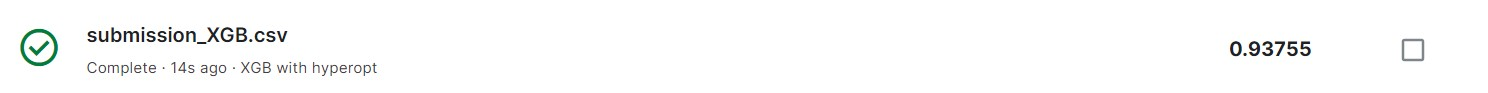

submission_xgb - саме цей варіант дав мені 2-ге та 3-є місце у privat and public leaderboard in accordance.

In [ ]:
X_test_lgb = X_test.copy()

In [ ]:
probability_lgb = final_clf_lgb.predict_proba(X_test)[:, 1]
probability_lgb

[LightGBM] [Warning] Unknown parameter: missing


array([0.10222368, 0.04832841, 0.09783894, ..., 0.03202498, 0.12947559,
       0.13206671])

In [ ]:
X_test_lgb['Exited'] = probability_lgb
X_test_lgb.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
id,,,,,,,,,,,,,
15000,15594796.0,Chu,584.0,Germany,Male,30.0,2.0,146053.66,1.0,1.0,1.0,157891.86,0.102224
15001,15642821.0,Mazzi,551.0,France,Male,39.0,5.0,0.00,2.0,1.0,1.0,67431.28,0.048328
15002,15716284.0,Onyekachi,706.0,France,Male,43.0,8.0,0.00,2.0,1.0,0.0,156768.45,0.097839
15003,15785078.0,Martin,717.0,Spain,Male,45.0,3.0,0.00,1.0,1.0,1.0,166909.87,0.521956
15004,15662955.0,Kenechukwu,592.0,Spain,Male,43.0,8.0,0.00,2.0,1.0,1.0,143681.97,0.067011


In [ ]:
submission_lgb = pd.read_csv('sample_submission.csv')

In [ ]:
submission_lgb['Exited'] = X_test_lgb['Exited'].values

submission_lgb.head()

,id,Exited
0,15000,0.102224
1,15001,0.048328
2,15002,0.097839
3,15003,0.521956
4,15004,0.067011


In [ ]:
submission_lgb.to_csv('submission_LGB.csv', index=False)

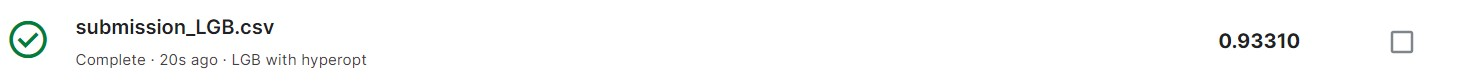